In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import sys
import copy

import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.io import savemat
import scipy.signal

import torch
import torchvision
import torchvision.transforms as transforms

import os

# for reading and displaying images
from skimage.io import imread
# for creating validation set
from sklearn.model_selection import train_test_split
# for evaluating the model
from sklearn.metrics import accuracy_score

import pathlib
from imgaug import augmenters as iaa


%matplotlib notebook
%matplotlib notebook
%matplotlib inline
# %matplotlib qt

In [3]:
# torch.cuda.current_device()

In [4]:
# torch.cuda.get_device_name(0)

In [5]:
dup_num = 1

Load and preprocess stat file and labels  
Labels must be made in the 'ROI_labeling_and_augmentation' script and the relabeling script  
## outputs: 'images' and 'labels' (both input into CNN)


In [6]:
def load_npy(base_dir='label_data', subpath='mouse 6_28 _ day 20200903', lbl=''):
    
    # dir_load = '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\round 4 experiments\\mouse 6.28\\20200815\\suite2p\\plane0\\'
    fileName_load = 'stat.npy'

    PATH_absolute = pathlib.Path('.').absolute()
    
    PATH_load_dir_statFile = f'{PATH_absolute}/{base_dir}/{subpath}/'
    # PATH_load_dir_statFile = '/media/rich/Home_Linux_partition/GoogleDrive_ocaml_cache/Research/Sabatini Lab Stuff - working/Code/PYTHON/ROI_Classifiers/test data_mouse6_28 _ 20200815/'
    print(f'PATH:   {PATH_load_dir_statFile}{fileName_load}')
    print('')

    stat = np.load(f'{PATH_load_dir_statFile}{fileName_load}', allow_pickle=True)
    print('stat file loaded')
    print('')

    num_ROI = stat.shape[0]
    print(f'Number of ROIs: {num_ROI}')

    height = 512
    width = 1024
    spatial_footprints_centered = np.zeros((num_ROI, 241,241))
    for i in range(num_ROI):
        spatial_footprints_centered[i , stat[i]['ypix'] - np.int16(stat[i]['med'][0]) + 120, stat[i]['xpix'] - np.int16(stat[i]['med'][1]) + 120] = stat[i]['lam'] # this is formatted for coding ease (dim1: y pix) (dim2: x pix) (dim3: ROI#)
    spatial_footprints_centered_crop = spatial_footprints_centered[:, 102:138 , 102:138]

    # %matplotlib inline
    plt.figure()
    plt.imshow(np.max(spatial_footprints_centered_crop , axis=0) ** 0.2);
    plt.title(f'spatial_footprints_centered_crop{lbl} MIP^0.2');

    images = spatial_footprints_centered_crop
    return spatial_footprints_centered_crop

PATH:   /Users/josh/Documents/Harvard/GCaMP_ROI_classifier/ROIClassifier-tmp/../../label_data/mouse 6_28 _ day 20200903/stat.npy

stat file loaded

Number of ROIs: 4868


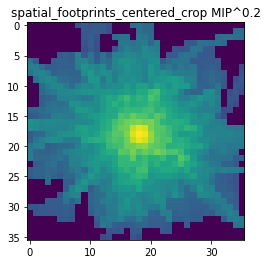

In [7]:
# LOAD stat.npy file 1
#___________________


spatial_footprints_centered_crop = load_npy(base_dir='../../label_data', subpath='mouse 6_28 _ day 20200903')
images = spatial_footprints_centered_crop


PATH:   /Users/josh/Documents/Harvard/GCaMP_ROI_classifier/ROIClassifier-tmp/../../label_data/mouse6_28 _ day20200815/stat.npy

stat file loaded

Number of ROIs: 4847


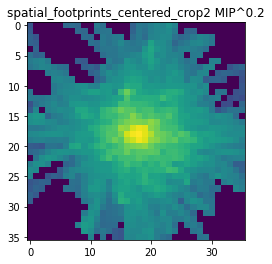

In [8]:
# # LOAD stat.npy file 2
# #___________________


spatial_footprints_centered_crop2 = load_npy(base_dir='../../label_data',
                                             subpath='mouse6_28 _ day20200815',
                                             lbl='2'
                                            )
images2 = spatial_footprints_centered_crop2


PATH:   /Users/josh/Documents/Harvard/GCaMP_ROI_classifier/ROIClassifier-tmp/../../label_data/mouseUnknownAi148__20210325/stat.npy

stat file loaded

Number of ROIs: 4893


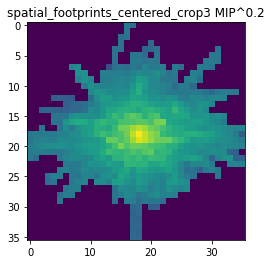

In [9]:
spatial_footprints_centered_crop3 = load_npy(base_dir='../../label_data',
                                             subpath='mouseUnknownAi148__20210325',
                                             lbl='3')
images3 = spatial_footprints_centered_crop3


PATH:   /Users/josh/Documents/Harvard/GCaMP_ROI_classifier/ROIClassifier-tmp/../../label_data/mouse2_6__20210409/stat.npy

stat file loaded

Number of ROIs: 4898


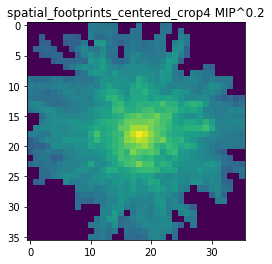

In [10]:
spatial_footprints_centered_crop4 = load_npy(base_dir='../../label_data',
                                             subpath='mouse2_6__20210409',
                                             lbl='4')
images4 = spatial_footprints_centered_crop4


In [11]:
images1 = spatial_footprints_centered_crop
images2 = spatial_footprints_centered_crop2


In [12]:
def load_labels(base_dir='../../label_data',
                 subpath='mouse 6_28 _ day 20200903',
                 fileName_load='labels_posthoc_filledIn_allCells.npy',
                 num_labels=6):
    
    PATH_absolute = pathlib.Path('.').absolute()
    
    PATH_load_dir_statFile = f'{PATH_absolute}/{base_dir}/{subpath}/'
    
    print(f'PATH:   {PATH_load_dir_statFile}{fileName_load}')
    print('')

    labels1 = np.load(f'{PATH_load_dir_statFile}{fileName_load}')
    print('labels file loaded')
    print('')


    plt.figure()
    # plt.hist(labels,20);
    plt.hist(labels1,20);


    #check in number of labels matches number of images
    if images.shape[0] == len(labels1):
        print('number of labels and images match')
    else:
        print('WARNING: number of labels and images DO NOT match')
    
    return labels1

PATH:   /Users/josh/Documents/Harvard/GCaMP_ROI_classifier/ROIClassifier-tmp/../../label_data/mouse 6_28 _ day 20200903/labels_posthoc_filledIn_allCells.npy

labels file loaded

number of labels and images match


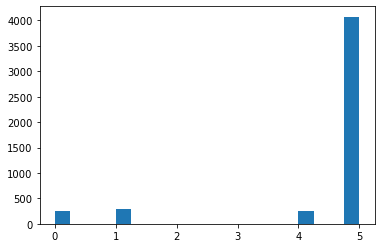

In [13]:
# # LOAD labels file 1
# #___________________

# num_labels = 6

# PATH_absolute = pathlib.Path('.').absolute()
# PATH_load_dir_statFile = f'{PATH_absolute}/label data/mouse 6_28 _ day 20200903/'
# fileName_load = 'labels_posthoc_filledIn_allCells.npy'
# print(f'PATH:   {PATH_load_dir_statFile}{fileName_load}')
# print('')

# labels1 = np.load(f'{PATH_load_dir_statFile}{fileName_load}')
# print('labels file loaded')
# print('')


# plt.figure()
# # plt.hist(labels,20);
# plt.hist(labels1,20);


# #check in number of labels matches number of images
# if images.shape[0] == len(labels1):
#     print('number of labels and images match')
# else:
#     print('WARNING: number of labels and images DO NOT match')


labels1 = load_labels(base_dir='../../label_data',
            subpath='mouse 6_28 _ day 20200903',
            fileName_load='labels_posthoc_filledIn_allCells.npy',
            num_labels=6)

In [14]:
images.shape, labels1.shape

((4868, 36, 36), (4868,))

PATH:   /Users/josh/Documents/Harvard/GCaMP_ROI_classifier/ROIClassifier-tmp/../../label_data/mouse6_28 _ day20200815/labels_posthoc_all.npy

labels file loaded



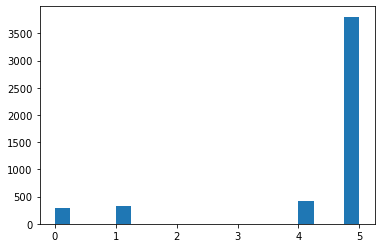

In [15]:
# # LOAD labels file 2
# #___________________

# num_labels = 6

# PATH_absolute = pathlib.Path('.').absolute()
# PATH_load_dir_statFile = f'{PATH_absolute}/label data/mouse6_28 _ day20200815/'
# fileName_load = 'labels_posthoc_all.npy'
# print(f'PATH:   {PATH_load_dir_statFile}{fileName_load}')
# print('')

# labels2 = np.load(f'{PATH_load_dir_statFile}{fileName_load}')
# print('labels file loaded')
# print('')


# plt.figure()
# # plt.hist(labels,20);
# plt.hist(labels2,20);


# #check in number of labels matches number of images
# if images.shape[0] == len(labels2):
#     print('number of labels and images match')
# else:
#     print('WARNING: number of labels and images DO NOT match')
    
    
    
labels2 = load_labels(base_dir='../../label_data',
            subpath='mouse6_28 _ day20200815',
            fileName_load='labels_posthoc_all.npy',
            num_labels=6)

PATH:   /Users/josh/Documents/Harvard/GCaMP_ROI_classifier/ROIClassifier-tmp/../../label_data/mouseUnknownAi148__20210325/labels_posthoc_mouseUnknownAi148__20210325.npy

labels file loaded



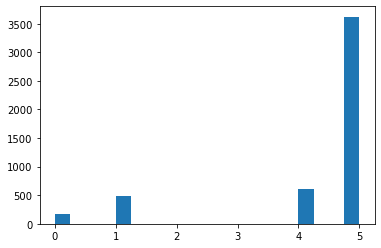

In [16]:
labels3 = load_labels(base_dir='../../label_data',
            subpath='mouseUnknownAi148__20210325',
            fileName_load='labels_posthoc_mouseUnknownAi148__20210325.npy',
            num_labels=6)

PATH:   /Users/josh/Documents/Harvard/GCaMP_ROI_classifier/ROIClassifier-tmp/../../label_data/mouse2_6__20210409/labels_posthoc_mouse2_6__20210409.npy

labels file loaded



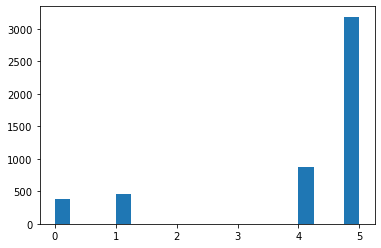

In [17]:
labels4 = load_labels(base_dir='../../label_data',
            subpath='mouse2_6__20210409',
            fileName_load='labels_posthoc_mouse2_6__20210409.npy',
            num_labels=6)

In [21]:
seed = 465
np.random.seed(seed)


# create validation set
train_x_i1, val_x_i1, train_y_i1, val_y_i1 = train_test_split(images1[:], labels1[:], test_size = 0.15)
train_x_i2, val_x_i2, train_y_i2, val_y_i2 = train_test_split(images2[:], labels2[:], test_size = 0.15)
train_x_i3, val_x_i3, train_y_i3, val_y_i3 = train_test_split(images3[:], labels3[:], test_size = 0.15)
train_x_i4, val_x_i4, train_y_i4, val_y_i4 = train_test_split(images4[:], labels4[:], test_size = 0.15)

# train_x, train_y = images, labels
# tea_x, tea_y = images3, labels3
# teb_x, teb_y = images4, labels4
# (train_x.shape, train_y.shape), (val_x.shape, val_y.shape), (tea_x.shape, tea_y.shape), (teb_x.shape, teb_y.shape)



images = np.concatenate((train_x_i1, train_x_i2, train_x_i3, train_x_i4) , axis = 0)
print(images.shape)

train_x = images

labels = np.concatenate((train_y_i1, train_y_i2, train_y_i3, train_y_i4))
print(labels.shape)

train_y = labels

val_x = np.concatenate((val_x_i1, val_x_i2, val_x_i3, val_x_i4) , axis = 0)
val_y = np.concatenate((val_y_i1, val_y_i2, val_y_i3, val_y_i4))

np.save('../../trash/temp_images.npy', images)
np.save('../../trash/temp_labels.npy', labels)


(16578, 36, 36)
(16578,)


In [22]:
# importing the libraries
import pandas as pd

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, Sigmoid, SELU, GELU, ELU, PReLU, Softplus, Softmax2d, AvgPool2d, Tanh
from torch.optim import Adam, SGD

counts = np.histogram(labels,np.arange(7))

weightings_groups_forSampling = np.zeros(6)
for ii in np.array([0,1,4,5]):
    weightings_groups_forSampling[ii] = np.max(counts[0]) / counts[0][ii]

plt.figure()
plt.bar(range(6), weightings_groups_forSampling)

# %matplotlib qt
weightings_forSampling = np.zeros(len(labels)) + 1e-9
for ii in range(len(weightings_forSampling)):
    weightings_forSampling[ii] = weightings_groups_forSampling[labels[ii]]

weightings_forSampling = weightings_forSampling / np.sum(weightings_forSampling)
plt.figure()
plt.plot(weightings_forSampling)
plt.plot(scipy.signal.savgol_filter(weightings_forSampling,11,2))

# light data augmentation
duplicates = 10

# duplication to equalize the probability of encountering each case

images_dup = train_x[0][None,:,:]
labels_aug = np.array([val_y[0]])

for ii in range(6):
    images_dup = np.concatenate( ( images_dup , np.tile(images[labels==ii] ,( np.int16(weightings_groups_forSampling[ii]) , 1 , 1 ) )), axis=0)
    labels_aug = np.concatenate( ( labels_aug , np.ones( np.int16(weightings_groups_forSampling[ii]) * np.sum(labels==ii) ) * ii) )
images_dup = np.tile(images_dup , (duplicates,1,1))
# images_dup = images_dup / np.tile(np.max(images_dup , axis=(1,2)) , (images_dup.shape[1], images_dup.shape[2], 1)).transpose(2,0,1) # noramlized all the images' max values to 1
labels_aug = np.tile(labels_aug , duplicates)

test = np.ones(images_dup.shape[0]) * np.nan
images_dup_int8 = np.int8(np.zeros_like(images_dup))
images_dup_uint8 = np.uint8(np.zeros_like(images_dup))
for ii , val in enumerate(images_dup):
    images_dup_int8[ii] = np.int8(np.round((( images_dup[ii] / np.max(images_dup[ii], axis=(0,1)) ) -0.5) * 122))
    images_dup_uint8[ii] = np.uint8(np.round((( images_dup[ii] / np.max(images_dup[ii], axis=(0,1)) )) * 122))
    test[ii] = np.mean(images_dup_uint8[ii], axis=(0,1))

In [23]:
duplicates = dup_num

images_dup = np.tile(train_x , (duplicates , 1 , 1))
labels_aug = np.tile(train_y , (duplicates))

print(images_dup.shape)
print(labels_aug.shape)

numToGetTo = np.sum(labels_aug==0)
print(numToGetTo)
for ii in np.array([1,4,5]):
#     idxToDelete = np.cumsum(labels_aug==ii) <= (np.sum(labels_aug==ii) - numToGetTo)
    if ii==5:
        numToGetTo = np.sum(labels_aug==0)/2
    else:
        numToGetTo = np.sum(labels_aug==0)

    idxToDelete = (np.cumsum(labels_aug==ii) * (labels_aug==ii)) > numToGetTo
    images_dup = images_dup[idxToDelete==0,:,:]
    labels_aug = labels_aug[idxToDelete==0]


print(np.sum(labels_aug==0))
print(np.sum(labels_aug==1))
print(np.sum(labels_aug==4))
print(np.sum(labels_aug==5))
print(images_dup.shape)
print(labels_aug.shape)

(16578, 36, 36)
(16578,)
913
913
913
913
456
(3196, 36, 36)
(3196,)


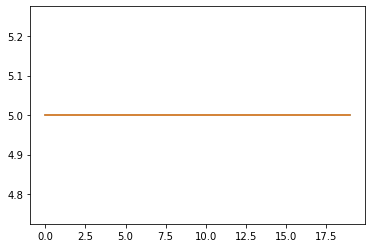

In [24]:
# %matplotlib inline
# %matplotlib inline

plt.figure()
plt.plot(labels_aug[:20])
plt.plot(train_y[:20])
# plt.plot(scipy.signal.savgol_filter(labels_aug , 11 , 3))

# plt.figure()
# plt.imshow(images_dup[5]);
# print(images_dup.dtype)

In [25]:
aug_seq = iaa.Sequential([], random_order=True) # apply augmenters in random order

np.save('images_aug.npy' , images_aug)

images_aug = np.load('images_aug.npy')

(3196, 36, 36)
float64
float64


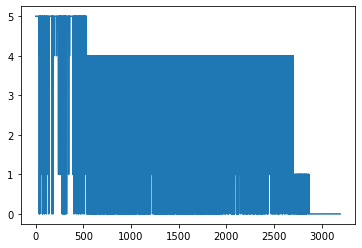

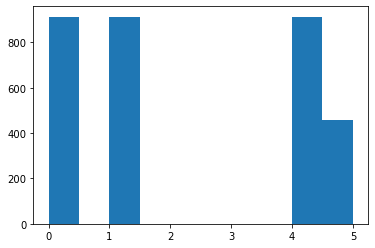

In [26]:
# images_aug = aug_seq(images=images_dup_uint8)
images_aug = aug_seq(images=images_dup)
# images_aug = images_dup
# images_aug = images_aug

# images_aug = images_aug / np.tile(np.max(images_aug , axis=(1,2)) , (images_aug.shape[1], images_aug.shape[2], 1)).transpose(2,0,1) # noramlized all the images' max values to 1

print(images_aug.shape)

# plt.figure()
# plt.imshow(images_dup_uint8[6])
plt.figure()
plt.plot(labels_aug)
plt.figure()
plt.hist(labels_aug);

print(images_dup.dtype)
print(images_aug.dtype)

# print(images_aug.shape)
# print(labels_aug.shape)

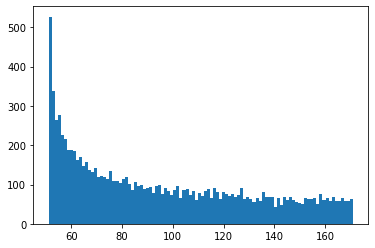

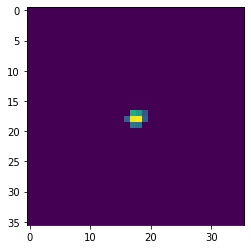

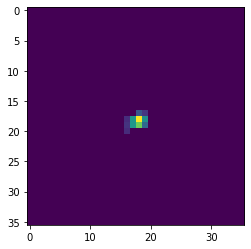

In [27]:
# noiseGain_inverse = np.random.rand(1)**2 * 100 + 10
# plt.figure()
# test = (100 * ( np.random.rand(10000) + 0.1 )**2)+12
# plt.hist(test[test < 1000],100);
noiseGain_inverse = lambda x: (100 * ( np.random.rand(x) + 0.1 )**2)+50
# noiseGain_inverse = lambda x: x

plt.figure()
plt.hist(noiseGain_inverse(10000),100)

images_toUse = images_aug

images_aug_noisy = np.zeros_like(images_toUse)
for ii in range(images_toUse.shape[0]):
    if np.random.rand(1) < 0.8:
        noise = noiseGain_inverse(1)
#         images_aug_noisy[ii] = np.random.poisson(images_toUse[ii] / np.max(images_toUse[ii]) ) * noise / noise * np.max(images_toUse[ii])   # noisy image
        images_aug_noisy[ii] = np.random.poisson(images_toUse[ii] / np.max(images_toUse[ii]) * noise) / noise * np.max(images_toUse[ii])   # noisy image
    else:
        images_aug_noisy[ii] = images_toUse[ii]
plt.figure()
plt.imshow(images_aug_noisy[0])
plt.figure()
plt.imshow(images_aug_noisy[1])

np.save('images_aug.npy' , images_aug)

<IPython.core.display.Javascript object>


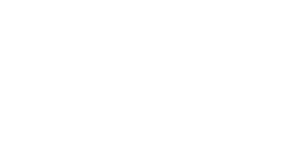

1.0196331659848277


In [28]:
%matplotlib notebook
plt.figure()
plt.imshow(images_aug_noisy[8])
print(np.sum(images_aug_noisy[8]))

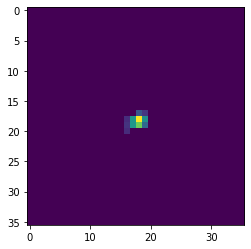

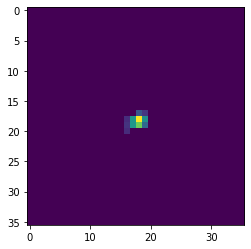

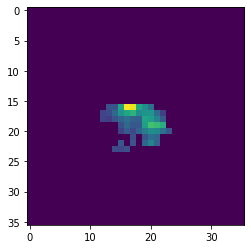

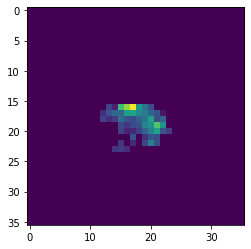

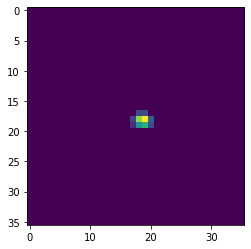

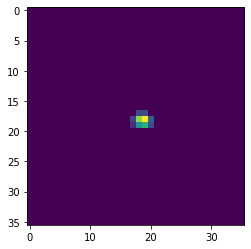

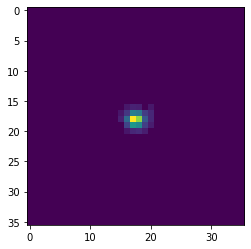

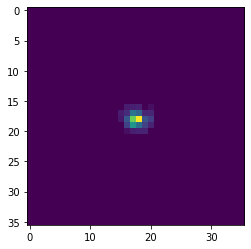

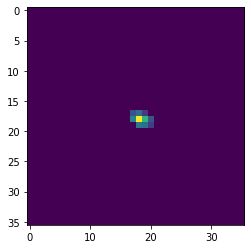

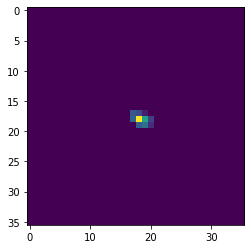

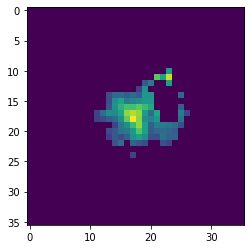

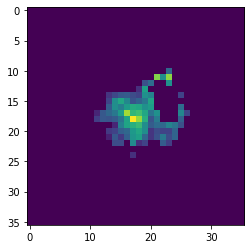

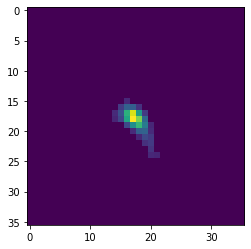

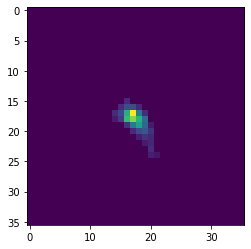

In [29]:
%matplotlib inline
plt.figure()
plt.imshow(images_dup[1])
plt.figure()
plt.imshow(images_aug_noisy[1])
plt.figure()
plt.imshow(images_dup[5])
plt.figure()
plt.imshow(images_aug_noisy[5])
plt.figure()
plt.imshow(images_dup[6])
plt.figure()
plt.imshow(images_aug_noisy[6])
plt.figure()
plt.imshow(images_dup[7])
plt.figure()
plt.imshow(images_aug_noisy[7])
plt.figure()
plt.imshow(images_dup[8])
plt.figure()
plt.imshow(images_aug_noisy[8])
plt.figure()
plt.imshow(images_dup[9])
plt.figure()
plt.imshow(images_aug_noisy[9])
plt.figure()
plt.imshow(images_dup[10])
plt.figure()
plt.imshow(images_aug_noisy[10])

0.3671784589535457
0.0
5.0
0.0
(3196, 1, 36, 36)
(3196,)


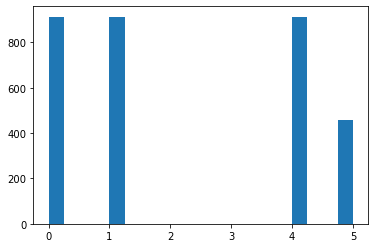

In [30]:
images_toUse = copy.deepcopy(images_aug)

# normalize
for ii in range(images_toUse.shape[0]):
    images_toUse[ii] = images_toUse[ii] / np.sum(images_toUse[ii]) 

# %matplotlib inline
# data_y = copy.deepcopy(labels[:643])
# data_y = np.int16(data_y - 1)

# data_y = train_y
# data_y = copy.deepcopy(labels_posthoc_filledIn)
data_y = copy.deepcopy(labels_aug)
# data_y = labels
# data_y = copy.deepcopy(train_y)

# data_x = images[:643,:,:]
# data_x = images
# data_x = train_x
# data_x = images_aug
# data_x = images_aug_noisy
data_x = images_toUse
# data_x = images_dup
# data_x = data_x / np.max(np.max(data_x, axis=2) , axis=1)[:,None,None]


# sample_submission = pd.read_csv('sample_submission_I5njJSF.csv')

# train.head()

print(np.max(data_x))
print(np.min(data_x))
print(np.max(data_y))
print(np.min(data_y))
# plt.figure()
# plt.imshow(np.squeeze(data_y[3,:,:,:]))
# data_y
plt.figure()
plt.hist(data_y,20);

# converting training images into torch format
data_x = data_x[:,None,:,:]
# train_x  = torch.from_numpy(train_x)
#data_x = torch.as_tensor(data_x)#.type('torch.cuda.FloatTensor')

# converting the target into torch format
data_y = data_y.astype(int);
# train_y = torch.from_numpy(train_y)
#data_y = torch.as_tensor(data_y)#.type('torch.cuda.LongTensor')

# shape of training data
print(data_x.shape)
print(data_y.shape)

In [31]:
data_x.shape

(3196, 1, 36, 36)

In [32]:
heldOut_x = val_x[: , None , : , :] #torch.as_tensor(val_x[: , None , : , :])#.type('torch.cuda.FloatTensor')
heldOut_y = val_y.astype(int) #torch.as_tensor(val_y.astype(int))#.type('torch.cuda.LongTensor')

# hO_tea_x = tea_x[: , None , : , :]
# hO_tea_y = tea_y.astype(int)
# hO_teb_x = teb_x[: , None , : , :]
# hO_teb_y = teb_y.astype(int)
print(heldOut_x.shape)
print(heldOut_y.shape)

(2928, 1, 36, 36)
(2928,)


In [33]:
from sklearn.metrics import accuracy_score
import tensorflow as tf
keras = tf.keras
layers = keras.layers
regularizers = keras.regularizers

# Reorganize "x" Data to Have Channels as Last Dimension
reorg_x = lambda x: np.transpose(x,(0,2,3,1))

In [34]:
# Define LeNet Architecture (with L1 / L2 regularization in place of DropOut)

l1_reg = 1e-5
l2_reg = 1e-4

rich_model_l12 = keras.Sequential([
    layers.Conv2D(16, 5, (1,1),
                        kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)
                       ),
    layers.Activation(keras.activations.relu),
    layers.Conv2D(16, 5, (1,1),
                        kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)
                       ),
    layers.MaxPool2D((2,2), 2),
    layers.Activation(keras.activations.relu),
    layers.Conv2D(32, 5, (1,1), padding='same',
                        kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)
                       ),
    layers.MaxPool2D((2,2), 2),
    layers.Activation(keras.activations.relu),
    layers.Conv2D(64, 5, (1,1),
                        kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)
                       ),
    layers.MaxPool2D((2,2), 2),
    layers.Activation(keras.activations.relu),
    
    layers.Flatten(),
    
    layers.Dense(256),
    layers.Activation(keras.activations.relu),
    layers.Dense(6)
    
])

dropout_prob = 0.4

rich_model = keras.Sequential([
    layers.Conv2D(16, 5, (1,1)),
    layers.Activation(keras.activations.relu),
    layers.Conv2D(16, 5, (1,1)),
    layers.MaxPool2D((2,2), 2),
    layers.Activation(keras.activations.relu),
    
    layers.Dropout(dropout_prob*1),
    
    
    
    
    
    
    layers.Conv2D(32, 5, (1,1), padding='same'),
    layers.MaxPool2D((2,2), 2),
    layers.Activation(keras.activations.relu),
    
    layers.Dropout(dropout_prob*1),
    
    
    
    
    
    
    
    layers.Conv2D(64, 5, (1,1)),
    layers.MaxPool2D((2,2), 2),
    layers.Activation(keras.activations.relu),
    
    layers.Dropout(dropout_prob*1),   
    
    
    
    
    
    
    
    layers.Flatten(),
    
    layers.Dense(256),
    layers.Activation(keras.activations.relu),
    
    layers.Dropout(dropout_prob*1),
    
    layers.Dense(6)
    
])



In [35]:
# Define an identity block for ResNet
# Adapted From: https://github.com/keras-team/keras-applications/blob/master/keras_applications/resnet50.py
def make_ResNet_conv_block(inp,
                           kernel_size=5,
                           filt=(16,32,64),
                           strides=(2,2),
                           l1_reg=1e-5,
                           l2_reg=1e-4):
    
    filt1, filt2, filt3 = filt[0], filt[1], filt[2]

    prv = layers.Conv2D(filt1, (1, 1), strides,
                        kernel_initializer='he_normal',
                        kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)
                       )(inp)
    prv = layers.BatchNormalization(axis=3)(prv)
    prv = layers.Activation('relu')(prv)

    prv = layers.Conv2D(filt2, (kernel_size, kernel_size), (1,1),
                        kernel_initializer='he_normal', padding='same',
                        kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)
                       )(prv)
    prv = layers.BatchNormalization(axis=3)(prv)
    prv = layers.Activation('relu')(prv)

    prv = layers.Conv2D(filt3, (1, 1), (1,1),
                        kernel_initializer='he_normal',
                        kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)
                       )(prv)
    prv = layers.BatchNormalization(axis=3)(prv)

    shrt = layers.Conv2D(filt3, (1,1), strides,
                        kernel_initializer='he_normal',
                        kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)
                       )(inp)
    shrt = layers.BatchNormalization(axis=3)(shrt)

    prv = layers.Lambda(lambda x: x[0] + x[1])([prv, shrt])

    return prv
    

In [36]:
# Define an identity block for ResNet
# Adapted From: https://github.com/keras-team/keras-applications/blob/master/keras_applications/resnet50.py
def make_ResNet_id_block(inp,
                           kernel_size=5,
                           filt=(16,32,64),
                           l1_reg=1e-5,
                           l2_reg=1e-4):
    
    filt1, filt2, filt3 = filt[0], filt[1], filt[2]

    prv = layers.Conv2D(filt1, (1, 1), (1,1),
                        kernel_initializer='he_normal',
                        kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)
                       )(inp)
    prv = layers.BatchNormalization(axis=3)(prv)
    prv = layers.Activation('relu')(prv)

    prv = layers.Conv2D(filt2, (kernel_size, kernel_size), (1,1),
                        kernel_initializer='he_normal', padding='same',
                        kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)
                       )(prv)
    prv = layers.BatchNormalization(axis=3)(prv)
    prv = layers.Activation('relu')(prv)

    prv = layers.Conv2D(filt3, (1, 1), (1,1),
                        kernel_initializer='he_normal',
                        kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)
                       )(prv)
    prv = layers.BatchNormalization(axis=3)(prv)

    prv = layers.Lambda(lambda x: x[0] + x[1])([prv, inp])

    return prv
    

In [37]:
tf.random.set_seed(seed)

# Create ResNet Architecture

inp = layers.Input(shape=reorg_x(data_x).shape[1:])

prv = inp

# prv = layers.ZeroPadding2D(padding=(3, 3))(prv)
# prv = layers.Conv2D(64, (7, 7),
#                   strides=(2, 2),
#                   padding='valid',
#                   kernel_initializer='he_normal')(prv)
# prv = layers.BatchNormalization(axis=3)(prv)
# prv = layers.Activation('relu')(prv)
# prv = layers.ZeroPadding2D(padding=(1, 1))(prv)
# prv = layers.MaxPooling2D((3, 3), strides=(2, 2))(prv)


prv = make_ResNet_conv_block(prv, 5, [64, 64, 128], strides=(1,1))
prv = make_ResNet_id_block(prv, 5, [64, 64, 128])
prv = make_ResNet_id_block(prv, 5, [64, 64, 128])


# prv = make_ResNet_conv_block(prv, 5, [16, 32, 64], strides=(1,1))
# prv = make_ResNet_id_block(prv, 5, [16, 32, 64],
#                            l1_reg=1e-8,
#                            l2_reg=1e-7)
# prv = make_ResNet_id_block(prv, 5, [16, 32, 64],
#                            l1_reg=1e-8,
#                            l2_reg=1e-7)

# prv = make_ResNet_conv_block(prv, 3, [128, 128, 512])
# prv = make_ResNet_id_block(prv, 3, [128, 128, 512])
# prv = make_ResNet_id_block(prv, 3, [128, 128, 512])
# prv = make_ResNet_id_block(prv, 3, [128, 128, 512])

# prv = make_ResNet_conv_block(prv, 3, [256, 256, 1024])
# prv = make_ResNet_id_block(prv, 3, [256, 256, 1024])
# prv = make_ResNet_id_block(prv, 3, [256, 256, 1024])
# prv = make_ResNet_id_block(prv, 3, [256, 256, 1024])
# prv = make_ResNet_id_block(prv, 3, [256, 256, 1024])
# prv = make_ResNet_id_block(prv, 3, [256, 256, 1024])

# prv = make_ResNet_conv_block(prv, 3, [512, 512, 2048])
# prv = make_ResNet_id_block(prv, 3, [512, 512, 2048])
# prv = make_ResNet_id_block(prv, 3, [512, 512, 2048])

prv = layers.Flatten()(prv)
prv = layers.Dense(256)(prv)
prv = layers.Activation(keras.activations.relu)(prv)

# prv = layers.GlobalMaxPooling2D()(prv)

# out = layers.Dense(6, activation='softmax')(prv)
out = layers.Dense(6)(prv)

# out = prv

jz_model = keras.Model(inputs=[inp], outputs=[out])

In [38]:
prv.shape

TensorShape([None, 256])

In [39]:
# Select Model Architecture to Train

# model = rich_model
model = jz_model

In [40]:
# Data Augmentation Generator
# Adapted from: https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=180,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=30,
    width_shift_range=(-0.05,0.05),
    height_shift_range=(-0.05,0.05),
#     brightness_range=(-0.1, 0.1),
    zoom_range=(0.6, 1.7),
#     preprocessing_function=lambda x: x / np.sum(x) 
)

In [41]:
# Compile Model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
             )


# Save Training Curve Data
history = model.fit(datagen.flow(reorg_x(data_x), data_y, batch_size=32),
                    validation_data=(reorg_x(heldOut_x), heldOut_y),
                    callbacks=keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=20,
                                                            restore_best_weights=True),

                    epochs=200)

res_name = 'resnet_2i'

f'../../models/{res_name}'

Epoch 1/200
100/100 [==============================] - 73s 728ms/step - loss: 1.5778 - accuracy: 0.4540 - val_loss: 3.6793 - val_accuracy: 0.0867
Epoch 2/200
100/100 [==============================] - 72s 716ms/step - loss: 1.3582 - accuracy: 0.5016 - val_loss: 4.0961 - val_accuracy: 0.0786
Epoch 3/200
100/100 [==============================] - 72s 722ms/step - loss: 1.3027 - accuracy: 0.5263 - val_loss: 4.5624 - val_accuracy: 0.0939
Epoch 4/200
100/100 [==============================] - 71s 710ms/step - loss: 1.2519 - accuracy: 0.5435 - val_loss: 3.4403 - val_accuracy: 0.1042
Epoch 5/200
100/100 [==============================] - 68s 683ms/step - loss: 1.2211 - accuracy: 0.5616 - val_loss: 1.7505 - val_accuracy: 0.5895
Epoch 6/200
100/100 [==============================] - 67s 672ms/step - loss: 1.2113 - accuracy: 0.5701 - val_loss: 1.3460 - val_accuracy: 0.6636
Epoch 7/200
100/100 [==============================] - 67s 673ms/step - loss: 1.1741 - accuracy: 0.5954 - val_loss: 1.0314 -

Epoch 57/200
100/100 [==============================] - 72s 719ms/step - loss: 0.9010 - accuracy: 0.7356 - val_loss: 0.6956 - val_accuracy: 0.8405
Epoch 58/200
100/100 [==============================] - 70s 701ms/step - loss: 0.9084 - accuracy: 0.7334 - val_loss: 0.7022 - val_accuracy: 0.8402
Epoch 59/200
100/100 [==============================] - 70s 702ms/step - loss: 0.9311 - accuracy: 0.7200 - val_loss: 0.7370 - val_accuracy: 0.8258
Epoch 60/200
100/100 [==============================] - 81s 809ms/step - loss: 0.9171 - accuracy: 0.7225 - val_loss: 0.6582 - val_accuracy: 0.8487
Epoch 61/200
100/100 [==============================] - 80s 797ms/step - loss: 0.9128 - accuracy: 0.7247 - val_loss: 0.6893 - val_accuracy: 0.8467
Epoch 62/200
100/100 [==============================] - 81s 810ms/step - loss: 0.9310 - accuracy: 0.7153 - val_loss: 0.6451 - val_accuracy: 0.8576
Epoch 63/200
100/100 [==============================] - 76s 763ms/step - loss: 0.8970 - accuracy: 0.7400 - val_loss: 0

'../../models/resnet_2i'

In [42]:
model.save(f'../../{res_name}')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../../resnet_2i/assets


In [44]:
acc = keras.metrics.Accuracy()
acc.update_state(np.argmax(model.predict(reorg_x(val_x[:, None, :, :])),-1),val_y)
print('Val Accuracy CV Overall:',acc.result().numpy())

acc = keras.metrics.Accuracy()
acc.update_state(np.argmax(model.predict(reorg_x(val_x_i1[:, None, :, :])),-1),val_y_i1)
print('Val Accuracy CV1:',acc.result().numpy())

acc = keras.metrics.Accuracy()
acc.update_state(np.argmax(model.predict(reorg_x(val_x_i2[:, None, :, :])),-1),val_y_i2)
print('Val Accuracy CV2:',acc.result().numpy())

acc = keras.metrics.Accuracy()
acc.update_state(np.argmax(model.predict(reorg_x(val_x_i3[:, None, :, :])),-1),val_y_i3)
print('Val Accuracy CV3:',acc.result().numpy())

acc = keras.metrics.Accuracy()
acc.update_state(np.argmax(model.predict(reorg_x(val_x_i4[:, None, :, :])),-1),val_y_i4)
print('Val Accuracy CV4:',acc.result().numpy())

# acc_tea = keras.metrics.Accuracy()
# acc_tea.update_state(np.argmax(model.predict(reorg_x(hO_tea_x)),-1),hO_tea_y)
# print('Val Accuracy Test:',acc_tea.result().numpy())

# acc_teb = keras.metrics.Accuracy()
# acc_teb.update_state(np.argmax(model.predict(reorg_x(hO_teb_x)),-1),hO_teb_y)
# print('Val Accuracy Test:',acc_teb.result().numpy())

Val Accuracy CV Overall: 0.857582
Val Accuracy CV1: 0.8878249
Val Accuracy CV2: 0.91346157
Val Accuracy CV3: 0.8978202
Val Accuracy CV4: 0.7319728


In [45]:
from_logits = True

scc = keras.losses.SparseCategoricalCrossentropy(from_logits=from_logits)
sccpred = scc(val_y, model.predict(reorg_x(val_x[:, None, :, :]))).numpy()
# sccpred = scc(labels3.astype(int), model.predict(reorg_x(images3[: , None , : , :]))).numpy()
print('Val Loss CV Overall:',sccpred)

scc = keras.losses.SparseCategoricalCrossentropy(from_logits=from_logits)
sccpred = scc(val_y_i1, model.predict(reorg_x(val_x_i1[:, None, :, :]))).numpy()
print('Val Loss CV1:',sccpred)

scc = keras.losses.SparseCategoricalCrossentropy(from_logits=from_logits)
sccpred = scc(val_y_i2, model.predict(reorg_x(val_x_i2[:, None, :, :]))).numpy()
print('Val Loss CV2:',sccpred)

scc = keras.losses.SparseCategoricalCrossentropy(from_logits=from_logits)
sccpred = scc(val_y_i3, model.predict(reorg_x(val_x_i3[:, None, :, :]))).numpy()
print('Val Loss CV3:',sccpred)

scc = keras.losses.SparseCategoricalCrossentropy(from_logits=from_logits)
sccpred = scc(val_y_i4, model.predict(reorg_x(val_x_i4[:, None, :, :]))).numpy()
print('Val Loss CV4:',sccpred)


# scc_tea = keras.losses.SparseCategoricalCrossentropy(from_logits=from_logits)
# sccpred_tea = scc_tea(hO_tea_y, model.predict(reorg_x(hO_tea_x))).numpy()
# print('Val Loss Test:',sccpred_tea)

# scc_teb = keras.losses.SparseCategoricalCrossentropy(from_logits=from_logits)
# sccpred_teb = scc_teb(hO_teb_y, model.predict(reorg_x(hO_teb_x))).numpy()
# print('Val Loss Test:', sccpred_teb)

Val Loss CV Overall: 0.32248634
Val Loss CV1: 0.27298817
Val Loss CV2: 0.18669628
Val Loss CV3: 0.22035982
Val Loss CV4: 0.6081995


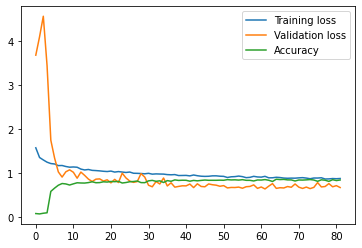

In [46]:
# Generate Training Curves

train_losses = history.history['loss']
val_losses = history.history['val_loss']
accuracy_running = history.history['val_accuracy']

%matplotlib inline
# plotting the training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss') 
plt.plot(accuracy_running, label='Accuracy')
plt.legend()
plt.show()


<ipython-input-47-e3109354e9fc>:26: RuntimeWarning: invalid value encountered in true_divide
  matrix_probability = (predictions_bool.T @ heldOut_y_bool) / matlib.repmat(np.sum(heldOut_y_bool,axis=0) , 6,1)


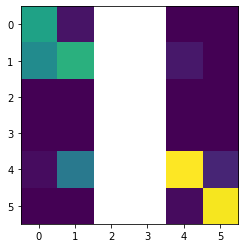

,0,1,2,3,4,5
0,0.527273,0.047244,NaN,NaN,0.000000,0.000000
1,0.442424,0.582677,NaN,NaN,0.057692,0.000455
2,0.000000,0.000000,NaN,NaN,0.000000,0.000000
3,0.000000,0.000000,NaN,NaN,0.000000,0.000000
4,0.030303,0.370079,NaN,NaN,0.916667,0.093764
5,0.000000,0.000000,NaN,NaN,0.025641,0.905781


In [47]:
xbasis = val_x[:, None, :, :]
ybasis = val_y

# Generate Confusion Matrix

%matplotlib inline

# chk_model = keras.models.load_model('resnet_1')
chk_model = model

output = chk_model.predict(reorg_x(xbasis))

prob = output
predictions = np.argmax(prob, axis=1)

# val_y_bool = np.zeros((len(val_y) , np.max(val_y.numpy())-1))
heldOut_y_bool = np.zeros((len(ybasis) , 6))
predictions_bool = np.zeros((len(ybasis) , 6))
for ii in range(6):
    heldOut_y_bool[:,ii] = (ybasis == ii)
    predictions_bool[:,ii] = (predictions==ii)
# plt.figure()
# plt.imshow(predictions_bool)

from numpy import matlib
matrix_probability = (predictions_bool.T @ heldOut_y_bool) / matlib.repmat(np.sum(heldOut_y_bool,axis=0) , 6,1)
plt.ion()
plt.figure()
plt.imshow(matrix_probability);
plt.show()

# Print Numerical Confusion Matrix
display(pd.DataFrame(matrix_probability))

<ipython-input-48-ec0909b170f8>:26: RuntimeWarning: invalid value encountered in true_divide
  matrix_probability = (predictions_bool.T @ heldOut_y_bool) / matlib.repmat(np.sum(heldOut_y_bool,axis=0) , 6,1)


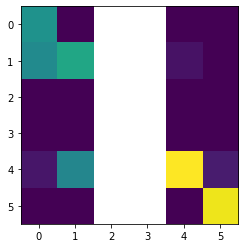

,0,1,2,3,4,5
0,0.485714,0.000000,NaN,NaN,0.000000,0.000000
1,0.457143,0.564103,NaN,NaN,0.047619,0.000000
2,0.000000,0.000000,NaN,NaN,0.000000,0.000000
3,0.000000,0.000000,NaN,NaN,0.000000,0.000000
4,0.057143,0.435897,NaN,NaN,0.952381,0.073171
5,0.000000,0.000000,NaN,NaN,0.000000,0.926829


In [48]:
xbasis = val_x_i1[:, None, :, :]
ybasis = val_y_i1

# Generate Confusion Matrix

%matplotlib inline

# chk_model = keras.models.load_model('resnet_1')
chk_model = model

output = chk_model.predict(reorg_x(xbasis))

prob = output
predictions = np.argmax(prob, axis=1)

# val_y_bool = np.zeros((len(val_y) , np.max(val_y.numpy())-1))
heldOut_y_bool = np.zeros((len(ybasis) , 6))
predictions_bool = np.zeros((len(ybasis) , 6))
for ii in range(6):
    heldOut_y_bool[:,ii] = (ybasis == ii)
    predictions_bool[:,ii] = (predictions==ii)
# plt.figure()
# plt.imshow(predictions_bool)

from numpy import matlib
matrix_probability = (predictions_bool.T @ heldOut_y_bool) / matlib.repmat(np.sum(heldOut_y_bool,axis=0) , 6,1)
plt.ion()
plt.figure()
plt.imshow(matrix_probability);
plt.show()

# Print Numerical Confusion Matrix
display(pd.DataFrame(matrix_probability))

<ipython-input-49-615062d7f9e6>:26: RuntimeWarning: invalid value encountered in true_divide
  matrix_probability = (predictions_bool.T @ heldOut_y_bool) / matlib.repmat(np.sum(heldOut_y_bool,axis=0) , 6,1)


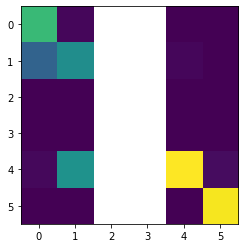

,0,1,2,3,4,5
0,0.666667,0.017857,NaN,NaN,0.000000,0.000000
1,0.311111,0.482143,NaN,NaN,0.017544,0.000000
2,0.000000,0.000000,NaN,NaN,0.000000,0.000000
3,0.000000,0.000000,NaN,NaN,0.000000,0.000000
4,0.022222,0.500000,NaN,NaN,0.982456,0.031579
5,0.000000,0.000000,NaN,NaN,0.000000,0.968421


In [49]:
xbasis = val_x_i2[:, None, :, :]
ybasis = val_y_i2

# Generate Confusion Matrix

%matplotlib inline

# chk_model = keras.models.load_model('resnet_1')
chk_model = model

output = chk_model.predict(reorg_x(xbasis))

prob = output
predictions = np.argmax(prob, axis=1)

# val_y_bool = np.zeros((len(val_y) , np.max(val_y.numpy())-1))
heldOut_y_bool = np.zeros((len(ybasis) , 6))
predictions_bool = np.zeros((len(ybasis) , 6))
for ii in range(6):
    heldOut_y_bool[:,ii] = (ybasis == ii)
    predictions_bool[:,ii] = (predictions==ii)
# plt.figure()
# plt.imshow(predictions_bool)

from numpy import matlib
matrix_probability = (predictions_bool.T @ heldOut_y_bool) / matlib.repmat(np.sum(heldOut_y_bool,axis=0) , 6,1)
plt.ion()
plt.figure()
plt.imshow(matrix_probability);
plt.show()

# Print Numerical Confusion Matrix
display(pd.DataFrame(matrix_probability))

<ipython-input-50-c25834128929>:26: RuntimeWarning: invalid value encountered in true_divide
  matrix_probability = (predictions_bool.T @ heldOut_y_bool) / matlib.repmat(np.sum(heldOut_y_bool,axis=0) , 6,1)


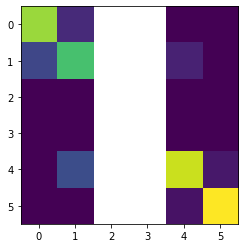

,0,1,2,3,4,5
0,0.8,0.111111,NaN,NaN,0.000000,0.000000
1,0.2,0.666667,NaN,NaN,0.089888,0.000000
2,0.0,0.000000,NaN,NaN,0.000000,0.000000
3,0.0,0.000000,NaN,NaN,0.000000,0.000000
4,0.0,0.222222,NaN,NaN,0.865169,0.058824
5,0.0,0.000000,NaN,NaN,0.044944,0.941176


In [50]:
xbasis = val_x_i3[:, None, :, :]
ybasis = val_y_i3

# Generate Confusion Matrix

%matplotlib inline

# chk_model = keras.models.load_model('resnet_1')
chk_model = model

output = chk_model.predict(reorg_x(xbasis))

prob = output
predictions = np.argmax(prob, axis=1)

# val_y_bool = np.zeros((len(val_y) , np.max(val_y.numpy())-1))
heldOut_y_bool = np.zeros((len(ybasis) , 6))
predictions_bool = np.zeros((len(ybasis) , 6))
for ii in range(6):
    heldOut_y_bool[:,ii] = (ybasis == ii)
    predictions_bool[:,ii] = (predictions==ii)
# plt.figure()
# plt.imshow(predictions_bool)

from numpy import matlib
matrix_probability = (predictions_bool.T @ heldOut_y_bool) / matlib.repmat(np.sum(heldOut_y_bool,axis=0) , 6,1)
plt.ion()
plt.figure()
plt.imshow(matrix_probability);
plt.show()

# Print Numerical Confusion Matrix
display(pd.DataFrame(matrix_probability))

<ipython-input-51-9b5dd8dd01fd>:26: RuntimeWarning: invalid value encountered in true_divide
  matrix_probability = (predictions_bool.T @ heldOut_y_bool) / matlib.repmat(np.sum(heldOut_y_bool,axis=0) , 6,1)


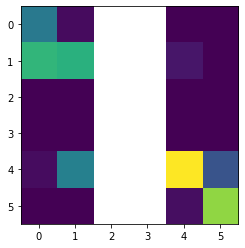

,0,1,2,3,4,5
0,0.369231,0.025641,NaN,NaN,0.000000,0.000000
1,0.600000,0.576923,NaN,NaN,0.056452,0.002137
2,0.000000,0.000000,NaN,NaN,0.000000,0.000000
3,0.000000,0.000000,NaN,NaN,0.000000,0.000000
4,0.030769,0.397436,NaN,NaN,0.911290,0.237179
5,0.000000,0.000000,NaN,NaN,0.032258,0.760684


In [51]:
xbasis = val_x_i4[:, None, :, :]
ybasis = val_y_i4

# Generate Confusion Matrix

%matplotlib inline

# chk_model = keras.models.load_model('resnet_1')
chk_model = model

output = chk_model.predict(reorg_x(xbasis))

prob = output
predictions = np.argmax(prob, axis=1)

# val_y_bool = np.zeros((len(val_y) , np.max(val_y.numpy())-1))
heldOut_y_bool = np.zeros((len(ybasis) , 6))
predictions_bool = np.zeros((len(ybasis) , 6))
for ii in range(6):
    heldOut_y_bool[:,ii] = (ybasis == ii)
    predictions_bool[:,ii] = (predictions==ii)
# plt.figure()
# plt.imshow(predictions_bool)

from numpy import matlib
matrix_probability = (predictions_bool.T @ heldOut_y_bool) / matlib.repmat(np.sum(heldOut_y_bool,axis=0) , 6,1)
plt.ion()
plt.figure()
plt.imshow(matrix_probability);
plt.show()

# Print Numerical Confusion Matrix
display(pd.DataFrame(matrix_probability))